### Import packages

In [1]:
import os
import sys
import warnings

import datetime
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th

import os
import pickle

import gymnasium as gym
import matplotlib.pyplot as plt

from datetime import datetime
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure  # Import the configure function
from stable_baselines3.common.utils import polyak_update, set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from scripts.utils import NumpyEncoder
from scripts.logger import *

import json


import seaborn as sns
sns.set(style="darkgrid")

### Hyperparameters


In [2]:
# In train_dqn_both_timesteps.ipynb:
if 'MAX_TOTAL_TIMESTEPS' not in globals():
    MAX_TOTAL_TIMESTEPS = 1000
if 'TRAINING_FOLDERS_PATH' not in globals():
    TRAINING_FOLDERS_PATH = "../data/Training/6ac-100-mixed-low/"
if 'SEEDS' not in globals():
    SEEDS = [0]
if 'brute_force_flag' not in globals():
    brute_force_flag = False




# Constants and Training Settings
LEARNING_RATE = 0.0001
GAMMA = 0.99
BUFFER_SIZE = 100000
BATCH_SIZE = 128
TARGET_UPDATE_INTERVAL = 1000
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256])
LEARNING_STARTS = 10000
TRAIN_FREQ = 4

EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 95

# EXPLORATION_PHASE = 1000
EPSILON_TYPE = "exponential"
# EPSILON_TYPE = "linear"
if EPSILON_TYPE == "linear":
    EPSILON_MIN = 0

N_EPISODES = 50 # DOESNT MATTER
cross_val_flag = False
CROSS_VAL_INTERVAL = N_EPISODES/100

# TRAINING_FOLDERS_PATH = "../data/Locked/alpha/"
# TRAINING_FOLDERS_PATH = "../data/Training/3ac-10/"
# TRAINING_FOLDERS_PATH = "../data/Training/temp/"
TESTING_FOLDERS_PATH = "../data/Training/3ac-10-deterministic/"


stripped_scenario_folder = TRAINING_FOLDERS_PATH.split("/")[-2]
print(f"Training on {stripped_scenario_folder}")
# extract number of scenarios in training and testing folders
num_scenarios_training = len(os.listdir(TRAINING_FOLDERS_PATH))



Training on 6ac-100-mixed-low


## ESTIMATED VALUES

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# based on MAX_TOTAL_TIMESTEPS and EPSILON_START = 1.0 andEPSILON_MIN = 0.025 andPERCENTAGE_MIN = 95, calculate EPSILON_DECAY_RATE
EPSILON_DECAY_RATE = calculate_epsilon_decay_rate(
    MAX_TOTAL_TIMESTEPS, EPSILON_START, EPSILON_MIN, PERCENTAGE_MIN, EPSILON_TYPE
)
print("EPSILON DECAY RATE: ", EPSILON_DECAY_RATE)


Calculated EPSILON_DECAY_RATE: 0.003883031004330459
EPSILON DECAY RATE:  0.003883031004330459


In [4]:
# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)
print(f"Device info: {device_info}")

# Verify training folders and gather training data
training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
# print(f"Training folders: {training_folders}")

# Calculate training days and model naming
num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
        f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
MODEL_SAVE_PATH = f'../trained_models/dqn/'

# Create results directory
results_dir = create_results_directory(append_to_name='dqn')
print(f"Results directory created at: {results_dir}")








Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training on 5000 days of data (50 episodes of 100 scenarios)
Results directory created at: ../results/dqn/20241208-16-15


# Reinforcement Learning

## Training

In [5]:
from scripts.logger import create_new_id, get_config_variables
import src.config as config

all_logs = {}
# Training both agents: myopic and proactive


def train_dqn_agent(env_type):
    log_data = {}  # Main dictionary to store all logs

    config_variables = get_config_variables(config)

    # Generate unique ID for training
    training_id = create_new_id("training")
    runtime_start_in_seconds = time.time()

    if env_type == "myopic":
        model_path = f"../trained_models/dqn/myopic-{training_id}.zip"
        print(f"Models will be saved to: {model_path}")
        model_path_and_name = model_path
    elif env_type == "proactive":
        model_path = f"../trained_models/dqn/proactive-{training_id}.zip"
        print(f"Models will be saved to: {model_path}")
        model_path_and_name = model_path
    # Metadata for logging
    training_metadata = {
        "myopic_or_proactive": env_type,
        "model_type": "dqn",
        "training_id": training_id,
        "MODEL_SAVE_PATH": model_path,
        "N_EPISODES": N_EPISODES,
        "num_scenarios_training": num_scenarios_training,
        "results_dir": results_dir,
        "CROSS_VAL_FLAG": cross_val_flag,
        "CROSS_VAL_INTERVAL": CROSS_VAL_INTERVAL,
        **config_variables,
        "LEARNING_RATE": LEARNING_RATE,
        "GAMMA": GAMMA,
        "BUFFER_SIZE": BUFFER_SIZE,
        "BATCH_SIZE": BATCH_SIZE,
        "TARGET_UPDATE_INTERVAL": TARGET_UPDATE_INTERVAL,
        "EPSILON_START": EPSILON_START,
        "EPSILON_MIN": EPSILON_MIN,
        "EPSILON_DECAY_RATE": EPSILON_DECAY_RATE,
        "LEARNING_STARTS": LEARNING_STARTS,
        "TRAIN_FREQ": TRAIN_FREQ,
        "NEURAL_NET_STRUCTURE": NEURAL_NET_STRUCTURE,
        "device_info": str(get_device_info(device)),
        "TRAINING_FOLDERS_PATH": TRAINING_FOLDERS_PATH,
        "TESTING_FOLDERS_PATH": TESTING_FOLDERS_PATH,
        "runtime_start": datetime.utcnow().isoformat() + "Z",
        "runtime_start_in_seconds": runtime_start_in_seconds,
    }

    log_data['metadata'] = training_metadata
    log_data['episodes'] = {}
    log_data['cross_validation'] = {}

    best_reward_avg = float('-inf')
    # Initialize variables
    rewards = {}
    good_rewards = {}
    test_rewards = []
    epsilon_values = []
    total_timesteps = 0  # Added to track total timesteps
    consecutive_drops = 0  # Track consecutive performance drops
    best_test_reward = float('-inf')  # Track best test performance
    action_sequences = {
        os.path.join(TRAINING_FOLDERS_PATH, folder): {
            "best_actions": [],
            "best_reward": float('-inf'),
            "worst_actions": [],
            "worst_reward": float('inf')
        }
        for folder in training_folders
    }
    
    def cross_validate_on_test_data(model, current_episode, log_data):
        cross_val_data = {
            "episode": current_episode,
            "scenarios": [],
            "avg_test_reward": 0,
        }

        test_scenario_folders = [
            os.path.join(TESTING_FOLDERS_PATH, folder)
            for folder in os.listdir(TESTING_FOLDERS_PATH)
            if os.path.isdir(os.path.join(TESTING_FOLDERS_PATH, folder))
        ]
        total_test_reward = 0
        for test_scenario_folder in test_scenario_folders:
            scenario_data = {
                "scenario_folder": test_scenario_folder,
                "total_reward": 0,
                "steps": []
            }
            # Load data
            data_dict = load_scenario_data(test_scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            from src.environment import AircraftDisruptionEnv
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Evaluate the model on the test scenario without training
            obs, _ = env.reset()

            done_flag = False
            total_reward = 0
            timesteps = 0

            while not done_flag:
                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -np.inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                # Select the action with the highest masked Q-value
                action = np.argmax(masked_q_values)

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result
                obs_next, reward, terminated, truncated, info = result

                done_flag = terminated or truncated

                # Accumulate the reward
                total_reward += reward

                # Update the current observation
                obs = obs_next

                scenario_data["steps"].append({
                    "step_number": timesteps + 1,
                    "action": action,
                    "flight_action": env.map_index_to_action(action)[0],
                    "aircraft_action": env.map_index_to_action(action)[1],
                    "reward": reward,
                    "total_timestep": total_timesteps,
                    "time_in_scenario": timesteps,
                    "epsilon": "1.0 at cross-validation",
                    "action_reason": "exploitation at cross-validation",
                    "action_mask": action_mask,
                    "action_mask_sum": np.sum(action_mask),
                    "len_action_mask": len(action_mask),
                    "masked_q_values": masked_q_values,
                    "q_values": q_values,
                    "info_after_step": env.info_after_step,
                    # Assuming impact_of_action is defined elsewhere
                    # "impact_of_action": impact_of_action,
                })

                timesteps += 1
                if done_flag:
                    break

            total_test_reward += total_reward

            scenario_data["total_reward"] = total_reward
            cross_val_data["scenarios"].append(scenario_data)

        # Compute average test reward
        avg_test_reward = total_test_reward / len(test_scenario_folders)
        cross_val_data["avg_test_reward"] = avg_test_reward
        test_rewards.append((current_episode, avg_test_reward))
        print(f"cross-val done at episode {current_episode}")

        # Store cross-validation data in log_data
        log_data['cross_validation'][current_episode] = cross_val_data

        return avg_test_reward  # Return the average test reward

    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    total_timesteps = 0  # Reset total_timesteps for each agent

    # Initialize the DQN
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    from src.environment import AircraftDisruptionEnv

    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict,
        env_type=env_type
    )

    model = DQN(
        policy='MultiInputPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device=device
    )

    logger = configure()
    model._logger = logger

    # Training loop over the number of episodes
    # for episode in range(N_EPISODES):

    episode = 0
    while total_timesteps < MAX_TOTAL_TIMESTEPS:    
        # create a dictionary in the rewards dictionary for the current episode
        rewards[episode] = {}
        # create a dictionary in the action_sequences dictionary for the current episode
        action_sequences[episode] = {}
        # Log the start of the episode
        episode_data = {
            "episode_number": episode + 1,
            "epsilon_start": epsilon,
            "scenarios": {},
        }
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            scenario_data = {
                "scenario_folder": scenario_folder,
                "steps": [],
                "total_reward": 0,
            }
            # create a dictionary in the rewards dictionary for the current scenario
            rewards[episode][scenario_folder] = {}
            # create a dictionary in the action_sequences dictionary for the current scenario
            action_sequences[episode][scenario_folder] = []
            best_reward = float('-inf')
            best_action_sequence = []
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=env_type
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag:

                # Get cancelled flights
                num_cancelled_flights_before_step = len(env.cancelled_flights)  # Returns a set of flight IDs

                # Get delayed flights and their delays (in minutes)
                num_delayed_flights_before_step = len(env.environment_delayed_flights)  # Returns a dict of {flight_id: delay_minutes}

                # Get flights that have already been penalized for delays
                num_penalized_delays_before_step = len(env.penalized_delays)  # Returns a dict of {flight_id: delay_minutes}

                # Get flights that have already been penalized for being cancelled
                num_penalized_cancelled_before_step = len(env.penalized_cancelled_flights)  # Returns a set of flight IDs

                model.exploration_rate = epsilon

                # Get the action mask from the environment
                action_mask = obs['action_mask']

                # Convert observation to float32
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

                # Preprocess observation and get Q-values
                obs_tensor = model.policy.obs_to_tensor(obs)[0]
                q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

                # Apply the action mask (set invalid actions to -np.inf)
                masked_q_values = q_values.copy()
                masked_q_values[action_mask == 0] = -np.inf

                current_seed = int(time.time() * 1e9) % (2**32 - 1)
                # print(current_seed)
                np.random.seed(current_seed)
                
                
                # Select an action
                action_reason = "None"
                if np.random.rand() < epsilon or brute_force_flag:
                    # Exploration: choose a random valid action
                    valid_actions = np.where(action_mask == 1)[0]
                    action = np.random.choice(valid_actions)
                    action_reason = "exploration"
                else:
                    # Exploitation: choose the action with the highest masked Q-value
                    action = np.argmax(masked_q_values)
                    action_reason = "exploitation"

                # Take the selected action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Store the reward for the current timestep
                rewards[episode][scenario_folder][timesteps] = reward
                action_sequences[episode][scenario_folder].append(action)

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                    
                epsilon_values.append((episode + 1, epsilon))

                timesteps += 1
                total_timesteps += 1  # Update total_timesteps

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                num_cancelled_flights_after_step = len(env.cancelled_flights)
                num_delayed_flights_after_step = len(env.environment_delayed_flights)
                num_penalized_delays_after_step = len(env.penalized_delays)
                num_penalized_cancelled_after_step = len(env.penalized_cancelled_flights)

                impact_of_action = {
                    "num_cancelled_flights": num_cancelled_flights_after_step - num_cancelled_flights_before_step,
                    "num_delayed_flights": num_delayed_flights_after_step - num_delayed_flights_before_step,
                    "num_penalized_delays": num_penalized_delays_after_step - num_penalized_delays_before_step,
                    "num_penalized_cancelled": num_penalized_cancelled_after_step - num_penalized_cancelled_before_step,
                }

                scenario_data["steps"].append({
                    "step_number": timesteps,
                    "action": action,
                    "flight_action": env.map_index_to_action(action)[0],
                    "aircraft_action": env.map_index_to_action(action)[1],
                    "reward": reward,
                    "total_timestep": total_timesteps,
                    "time_in_scenario": timesteps,
                    "epsilon": epsilon,
                    "action_reason": action_reason,
                    "impact_of_action": impact_of_action,
                    "done_flag": done_flag,
                    "action_mask_sum": np.sum(action_mask),
                    "len_action_mask": len(action_mask),
                    "info_after_step": env.info_after_step,
                    "masked_q_values": masked_q_values,
                    "q_values": q_values,
                    "action_mask": action_mask,
                })
                
                # Check if the episode is done
                if done_flag:
                    break
            
            total_reward = 0
            for _, reward in rewards[episode][scenario_folder].items():
                total_reward += reward
            # Store the total reward for the episode with the scenario specified while also keeping the step rewards
            rewards[episode][scenario_folder]["total"] = total_reward
            

            # save the action sequence
            action_sequences[episode][scenario_folder] = action_sequence

            # Summarize scenario
            scenario_data["total_reward"] = total_reward
            episode_data["scenarios"][scenario_folder] = scenario_data

        # Perform cross-validation at specified intervals
        if cross_val_flag:
            # Initialize best_test_reward and current_test_reward at first cross validation
            if (episode + 1) % CROSS_VAL_INTERVAL == 0:
                current_test_reward = cross_validate_on_test_data(model, episode + 1, log_data)
                if not hasattr(train_dqn_agent, 'best_test_reward'):
                    train_dqn_agent.best_test_reward = current_test_reward
                best_test_reward = train_dqn_agent.best_test_reward
            
                # Early stopping logic
                if current_test_reward < best_test_reward:
                    consecutive_drops += 1
                    print(f"Performance drop {consecutive_drops}/5 (current: {current_test_reward:.2f}, best: {best_test_reward:.2f})")
                    if consecutive_drops >= 500:
                        print(f"Early stopping triggered at episode {episode + 1} due to 5 consecutive drops in test performance")
                        break
                else:
                    consecutive_drops = 0
                    train_dqn_agent.best_test_reward = current_test_reward
                    best_test_reward = current_test_reward

        # Calculate the average reward for this batch of episodes
        avg_reward_for_this_batch = 0
        for i in range(len(scenario_folders)):
            avg_reward_for_this_batch += rewards[episode][scenario_folders[i]]["total"]
        avg_reward_for_this_batch /= len(scenario_folders)

        # Store avg_reward and total_timesteps in the current episode's dictionary:
        rewards[episode]["avg_reward"] = avg_reward_for_this_batch
        rewards[episode]["total_timesteps"] = total_timesteps

        print(f"({total_timesteps}/{MAX_TOTAL_TIMESTEPS}) {env_type} - episode {episode + 1} - epsilon {epsilon:.2f} - reward this episode: {avg_reward_for_this_batch:.2f}")
        # print(f"Total avg rewards for this batch: {avg_reward_for_this_batch}")

        # Summarize episode
        episode_data["avg_reward"] = avg_reward_for_this_batch
        log_data['episodes'][episode + 1] = episode_data
        episode += 1

    # Save the model after training
    if env_type == "myopic":
        model.save(f"../trained_models/dqn/myopic-{training_id}.zip")
    else:
        model.save(f"../trained_models/dqn/proactive-{training_id}.zip")

    runtime_end_in_seconds = time.time()
    runtime_in_seconds = runtime_end_in_seconds - runtime_start_in_seconds

    actual_total_timesteps = total_timesteps

    training_summary = {
        "runtime_seconds": runtime_in_seconds,
        "total_timesteps": total_timesteps,
        "final_rewards": good_rewards,
        "episodes_trained": episode + 1,
        "actual_total_timesteps": actual_total_timesteps,
    }
    log_data['training_summary'] = training_summary

    # Include all other relevant data
    log_data['average_batch_episode_rewards'] = good_rewards
    log_data['test_rewards'] = test_rewards
    log_data['epsilon_values'] = epsilon_values
    log_data['action_sequences'] = action_sequences
    log_data['rewards'] = rewards

    # Write all data to the log file at once
    log_file_path = os.path.join("../logs", "training", f"training_{training_id}.json")
    
    # make log_data serializable
    log_data = convert_to_serializable(log_data)
    with open(log_file_path, 'w') as log_file:
        json.dump(log_data, log_file, indent=4, cls=NumpyEncoder)


    finalize_training_log(training_id, training_summary, model_path)

    all_logs[training_id] = log_data
    # Return collected data
    return rewards, test_rewards, total_timesteps, epsilon_values, good_rewards, action_sequences, model_path_and_name


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Lists to store the results from all seeds
all_myopic_runs = []
all_proactive_runs = []
all_myopic_steps_runs = []
all_proactive_steps_runs = []

def run_training_for_seed(seed):
    import random
    import numpy as np
    import torch as th

    random.seed(seed)
    np.random.seed(seed)
    if th.cuda.is_available():
        th.cuda.manual_seed_all(seed)
    th.manual_seed(seed)

    # Train myopic agent
    (rewards_myopic, test_rewards_myopic, total_timesteps_myopic, 
     epsilon_values_myopic, good_rewards_myopic, action_sequences_myopic, 
     model_path_and_name_myopic) = train_dqn_agent('myopic')

    # Train proactive agent
    (rewards_proactive, test_rewards_proactive, total_timesteps_proactive, 
     epsilon_values_proactive, good_rewards_proactive, action_sequences_proactive, 
     model_path_and_name_proactive) = train_dqn_agent('proactive')

    return (rewards_myopic, rewards_proactive)


# Run training for each seed and store results
for s in SEEDS:
    print(f"Running DQN training for seed {s}...")
    rewards_myopic, rewards_proactive = run_training_for_seed(s)

    # Extract episode rewards and steps for myopic
    # episodes in rewards_myopic are keys like 0,1,2,... up to final trained episode
    # Check "avg_reward" and "total_timesteps" exist for that episode
    myopic_episode_rewards = [
        rewards_myopic[e]["avg_reward"] for e in sorted(rewards_myopic.keys())
        if "avg_reward" in rewards_myopic[e]
    ]
    myopic_episode_steps = [
        rewards_myopic[e]["total_timesteps"] for e in sorted(rewards_myopic.keys())
        if "total_timesteps" in rewards_myopic[e]
    ]

    # Extract episode rewards and steps for proactive
    proactive_episode_rewards = [
        rewards_proactive[e]["avg_reward"] for e in sorted(rewards_proactive.keys())
        if "avg_reward" in rewards_proactive[e]
    ]
    proactive_episode_steps = [
        rewards_proactive[e]["total_timesteps"] for e in sorted(rewards_proactive.keys())
        if "total_timesteps" in rewards_proactive[e]
    ]

    # Append these arrays to the main lists
    all_myopic_runs.append(myopic_episode_rewards)
    all_proactive_runs.append(proactive_episode_rewards)
    all_myopic_steps_runs.append(myopic_episode_steps)
    all_proactive_steps_runs.append(proactive_episode_steps)


# Ensure all runs are trimmed to the same length
# (In case different runs have different episode lengths)
print(f"episode lengths:")
for i in range(len(all_myopic_runs)):
    print(f"Myopic seed {i}: {len(all_myopic_runs[i])}")
for i in range(len(all_proactive_runs)):
    print(f"Proactive seed {i}: {len(all_proactive_runs[i])}")

min_length_myopic = min(len(run) for run in all_myopic_runs if len(run) > 0)
min_length_proactive = min(len(run) for run in all_proactive_runs if len(run) > 0)

all_myopic_runs = [run[:min_length_myopic] for run in all_myopic_runs]
all_proactive_runs = [run[:min_length_proactive] for run in all_proactive_runs]
all_myopic_steps_runs = [steps[:min_length_myopic] for steps in all_myopic_steps_runs]
all_proactive_steps_runs = [steps[:min_length_proactive] for steps in all_proactive_steps_runs]

# Convert to numpy arrays
all_myopic_runs = np.array(all_myopic_runs)              # shape: (num_seeds, num_episodes)
all_proactive_runs = np.array(all_proactive_runs)        # shape: (num_seeds, num_episodes)
all_myopic_steps_runs = np.array(all_myopic_steps_runs)  # shape: (num_seeds, num_episodes)
all_proactive_steps_runs = np.array(all_proactive_steps_runs)

# Calculate mean and std across seeds
myopic_mean = all_myopic_runs.mean(axis=0)
myopic_std = all_myopic_runs.std(axis=0)
proactive_mean = all_proactive_runs.mean(axis=0)
proactive_std = all_proactive_runs.std(axis=0)

myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)
proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)


Running DQN training for seed 0...
Models will be saved to: ../trained_models/dqn/myopic-0903.zip
Device: mps
Using MacBook M1
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-08-16-15-31-890724
(989/1000) myopic - episode 1 - epsilon 0.03 - reward this episode: 6553.33
(1981/1000) myopic - episode 2 - epsilon 0.03 - reward this episode: 6906.49
Marked logs_id 0903 as finished in ../logs/ids.json
Training log finalized and summary added to ../logs/training/training_0903.json
Models will be saved to: ../trained_models/dqn/proactive-0904.zip
Device: mps
Using MacBook M1
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-08-16-15-36-574860
(914/1000) proactive - episode 1 - epsilon 0.03 - reward this episode: 4289.53
(1911/1000) proactive - episode 2 - epsilon 0.03 - reward this episode: 6413.50
Marked logs_id 0904 as finished in ../logs/ids.json
Training log finalized and summary added to ../logs/training/training_0904.json
episode lengths:
Myo

In [7]:

num_seeds_myopic = all_myopic_runs.shape[0]
num_episodes_myopic = all_myopic_runs.shape[1] if num_seeds_myopic > 0 else 0
num_seeds_proactive = all_proactive_runs.shape[0]
num_episodes_proactive = all_proactive_runs.shape[1] if num_seeds_proactive > 0 else 0

for i in range(num_seeds_myopic):
    total_steps_myopic = all_myopic_steps_runs[i].sum()
    print(f"For seed index {i}, Myopic: finished {num_episodes_myopic} episodes, performed {total_steps_myopic} timesteps.")

for i in range(num_seeds_proactive):
    total_steps_proactive = all_proactive_steps_runs[i].sum()
    print(f"For seed index {i}, Proactive: finished {num_episodes_proactive} episodes, performed {total_steps_proactive} timesteps.")

For seed index 0, Myopic: finished 2 episodes, performed 2970 timesteps.
For seed index 0, Proactive: finished 2 episodes, performed 2825 timesteps.


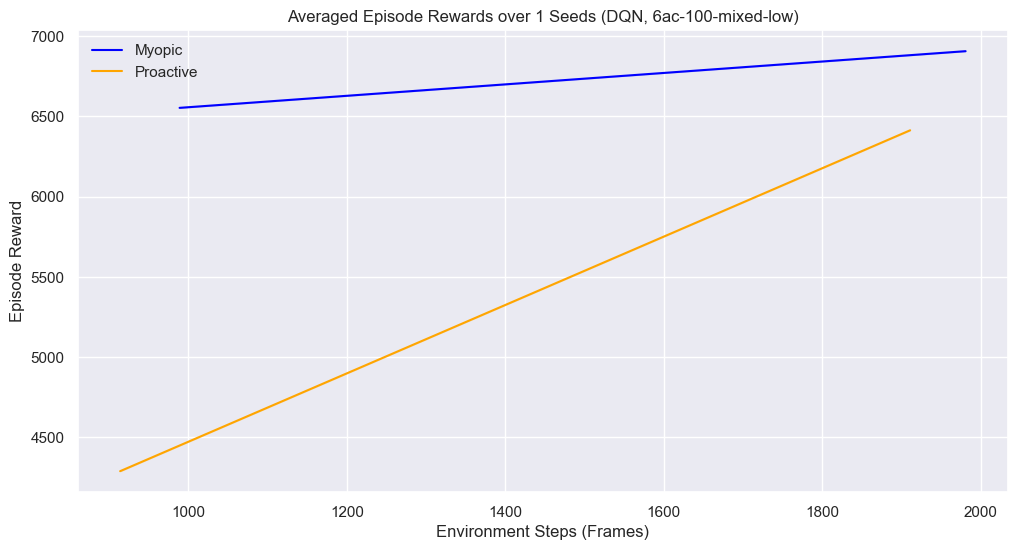

Averaged reward vs steps plot saved to ./results/averaged_rewards_over_steps_6ac-100-mixed-low.png


In [8]:

# Define a smoothing function
def smooth(data, window=10):
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Apply smoothing if desired
smooth_window = 4
myopic_mean_sm = smooth(myopic_mean, smooth_window)
myopic_std_sm = smooth(myopic_std, smooth_window)
myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

proactive_mean_sm = smooth(proactive_mean, smooth_window)
proactive_std_sm = smooth(proactive_std, smooth_window)
proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(myopic_steps_sm, myopic_mean_sm, label="Myopic", color='blue')
plt.fill_between(myopic_steps_sm, 
                 myopic_mean_sm - myopic_std_sm, 
                 myopic_mean_sm + myopic_std_sm, 
                 alpha=0.2, color='blue')

plt.plot(proactive_steps_sm, proactive_mean_sm, label="Proactive", color='orange')
plt.fill_between(proactive_steps_sm, 
                 proactive_mean_sm - proactive_std_sm, 
                 proactive_mean_sm + proactive_std_sm, 
                 alpha=0.2, color='orange')

plt.xlabel("Environment Steps (Frames)")
plt.ylabel("Episode Reward")
plt.title(f"Averaged Episode Rewards over {len(SEEDS)} Seeds (DQN, {stripped_scenario_folder})")
plt.legend(frameon=False)
plt.grid(True)


results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

plot_file = os.path.join(results_dir, f"averaged_rewards_over_steps_{stripped_scenario_folder}.png")
plt.savefig(plot_file)
plt.show()

print(f"Averaged reward vs steps plot saved to {plot_file}")


In [9]:
# save the raw rewards 